In [1]:
import numpy as np

import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
import prediction_regression_pipeline as prp
from adaptive_latents.plotting_functions import PredictionVideo
from adaptive_latents import (
    AnimationManager
)
import pandas as pd
from importlib import reload
from IPython import display



In [2]:
!echo $(hostname) $(git rev-parse --short HEAD)

tycho 433a5dc


# Odoherty21 Portion

## Intro video

A newer version (0.63.1) of dandi/dandi-cli is available. You are using 0.63.0
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


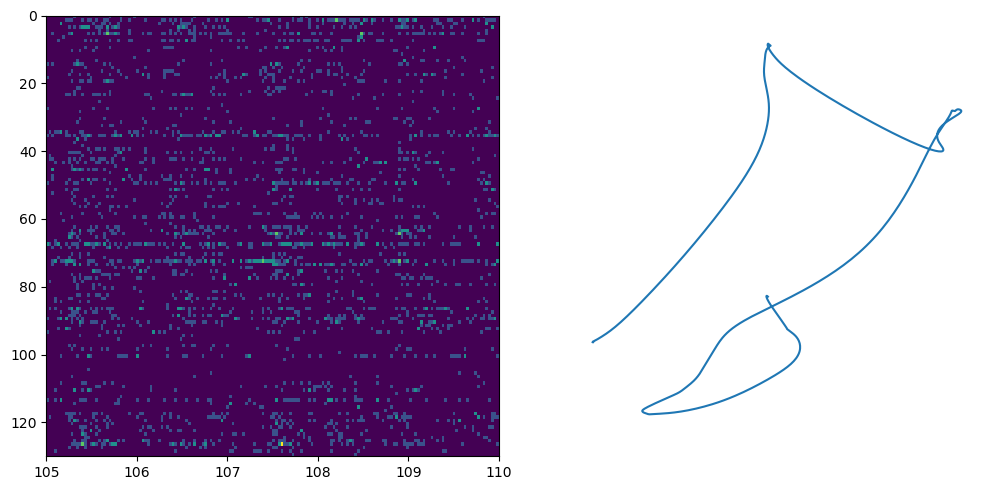

In [3]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()
        
display.display(display.Video())


## Trajectory with 2d histogram background

In [3]:
run = prp.PipelineRun(**prp.PipelineRun.default_parameter_values['odoherty21'])

A newer version (0.63.1) of dandi/dandi-cli is available. You are using 0.63.0
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/649.1 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/mmica/_densities.py", line 44:
@jit(parallel=True, fastmath=True, nopython=True)
def logp_u(Y):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


ValueError: autodetected range of [nan, nan] is not finite

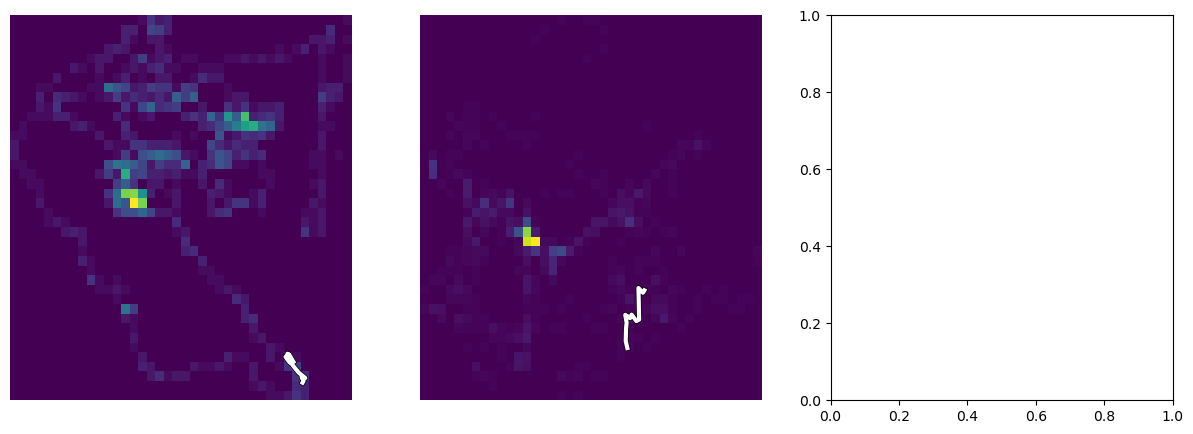

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

def plot_with_tail(ax, data, current_t, tail_length):
    ax.cla()
    # ax.axis('equal')
    ax.hist2d(data[:,0], data[:,1], 40)
    s = (current_t - tail_length < data.t) & (data.t < current_t)
    ax.plot(data[s,0], data[s,1], color='black', linewidth=4)
    ax.plot(data[s,0], data[s,1], color='white', linewidth=3)
    ax.axis('off')
    

current_t = 35
tail_length = 1

plot_with_tail(axs[0], run.neural_target, current_t, tail_length)
plot_with_tail(axs[1], run.jpca_latents,  current_t, tail_length)
plot_with_tail(axs[2], run.beh_target, current_t, tail_length)



## Data, Latent, Prediction graph

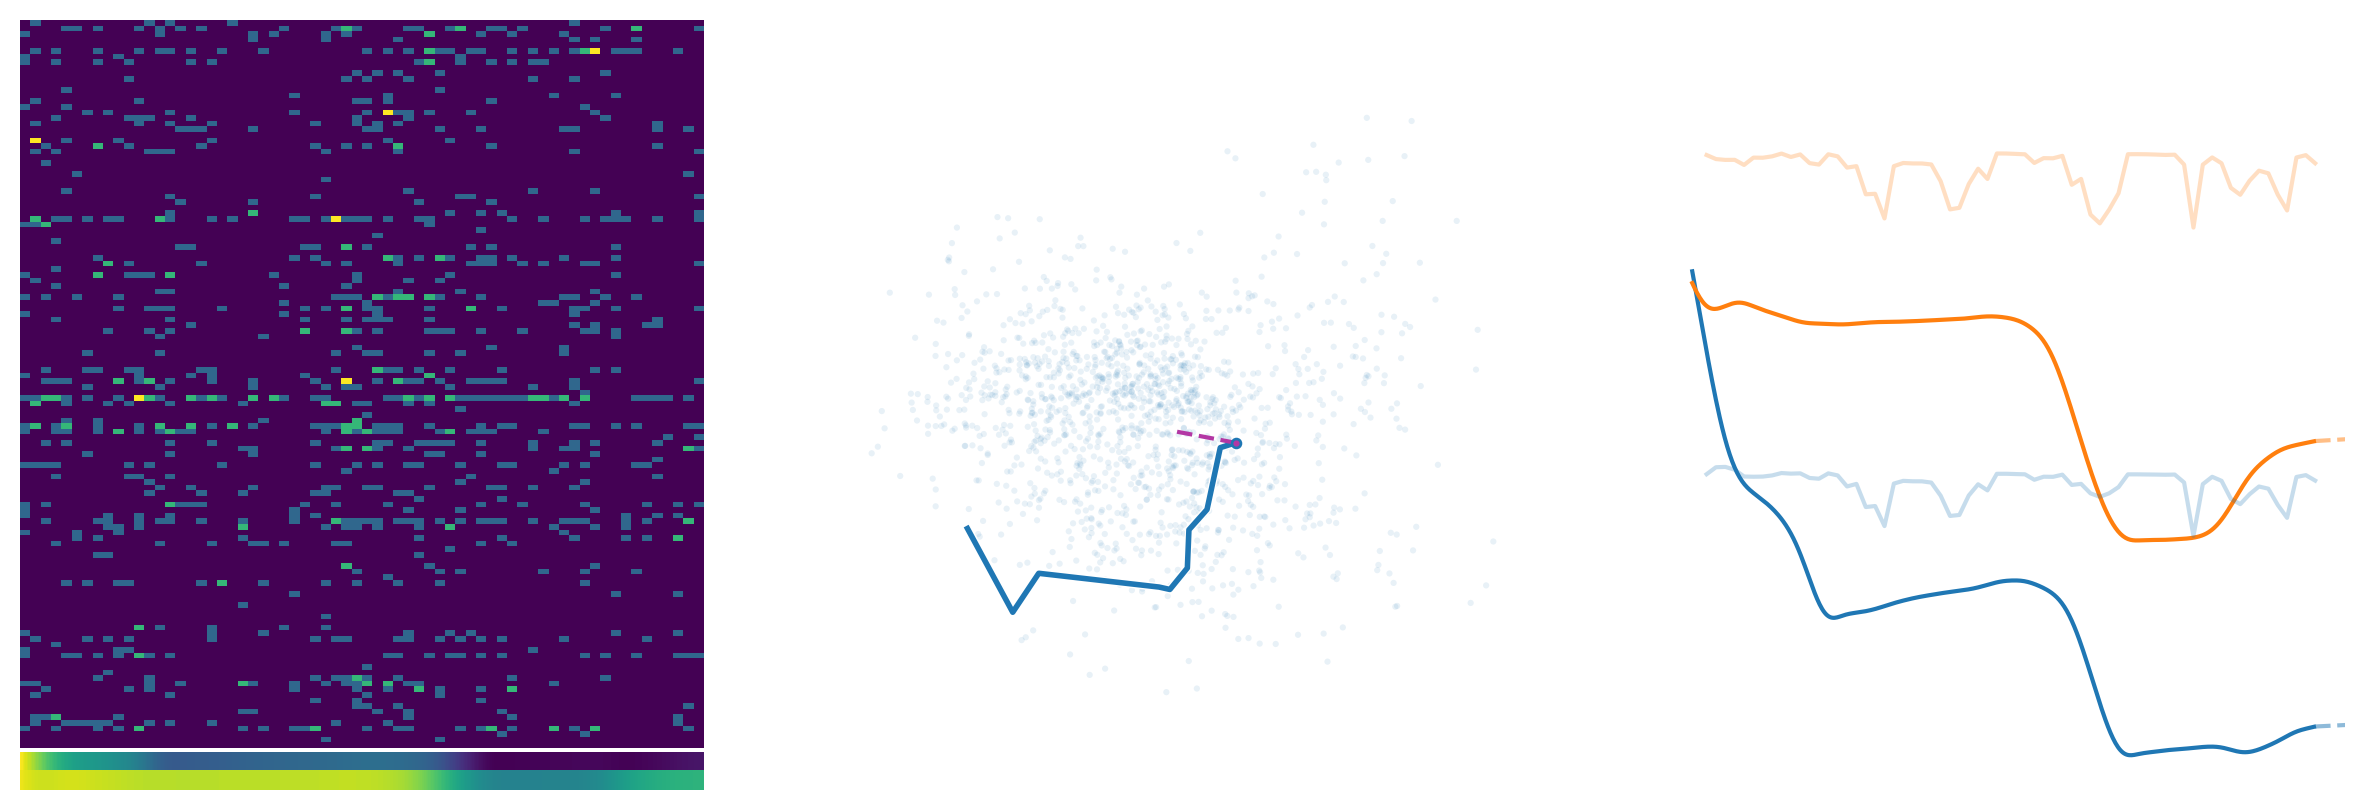

In [5]:
pv = PredictionVideo(run.d)

assert (run.next_bubble_joint_predictions.t == run.beh_predictions.t).all()
with pv.am:
    for current_t in np.linspace(35, 36, 10):
        pv.plot_for_video_t(
            current_t, 
            run.jpca_latents, run.jpca_latents.t, 
            run.next_bubble_joint_predictions, run.beh_predictions, run.beh_predictions.t,
            run.streams
        )

## Stream table

In [7]:
run_all = prp.PipelineRun(**(prp.PipelineRun.default_parameter_values['odoherty21']))
run_no_neural = prp.PipelineRun(**(prp.PipelineRun.default_parameter_values['odoherty21'] | dict(concat_zero_streams=[0])))
run_no_beh = prp.PipelineRun(**(prp.PipelineRun.default_parameter_values['odoherty21'] | dict(concat_zero_streams=[1])))


/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/649.1 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/649.1 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/649.1 [00:00<?, ?it/s]

In [21]:
def make_row(run):
    return ({
        'beh_x': run.beh_correlations[0],
        'beh_y': run.beh_correlations[1],
    } | {f'neural_{n}': run.neural_correlations[n] for n in range(len(run.neural_correlations))})
    
pd.DataFrame(
    [
        make_row(run_all),
        make_row(run_no_neural),
        make_row(run_no_beh)
    ], 
    index = ['all', 'no_neural', 'no_beh']
)

,beh_x,beh_y,neural_0,neural_1,neural_2,neural_3
all,-0.277227,-0.746600,-0.494954,0.230615,-0.234945,-0.037790
no_neural,-0.190296,0.418007,0.065579,0.293041,0.178244,0.209646
no_beh,0.133480,-0.402153,-0.432005,-0.078045,-0.333196,0.100002


# Zong22 Portion

In [2]:
run = prp.PipelineRun(**prp.PipelineRun.default_parameter_values['zong22'])

  0%|          | 0/579.9 [00:00<?, ?it/s]

/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/numba/core/typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/mmica/_densities.py", line 44:
@jit(parallel=True, fastmath=True, nopython=True)
def logp_u(Y):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


## Dimensionality reduction comparison

NameError: name 'plot_with_tail' is not defined

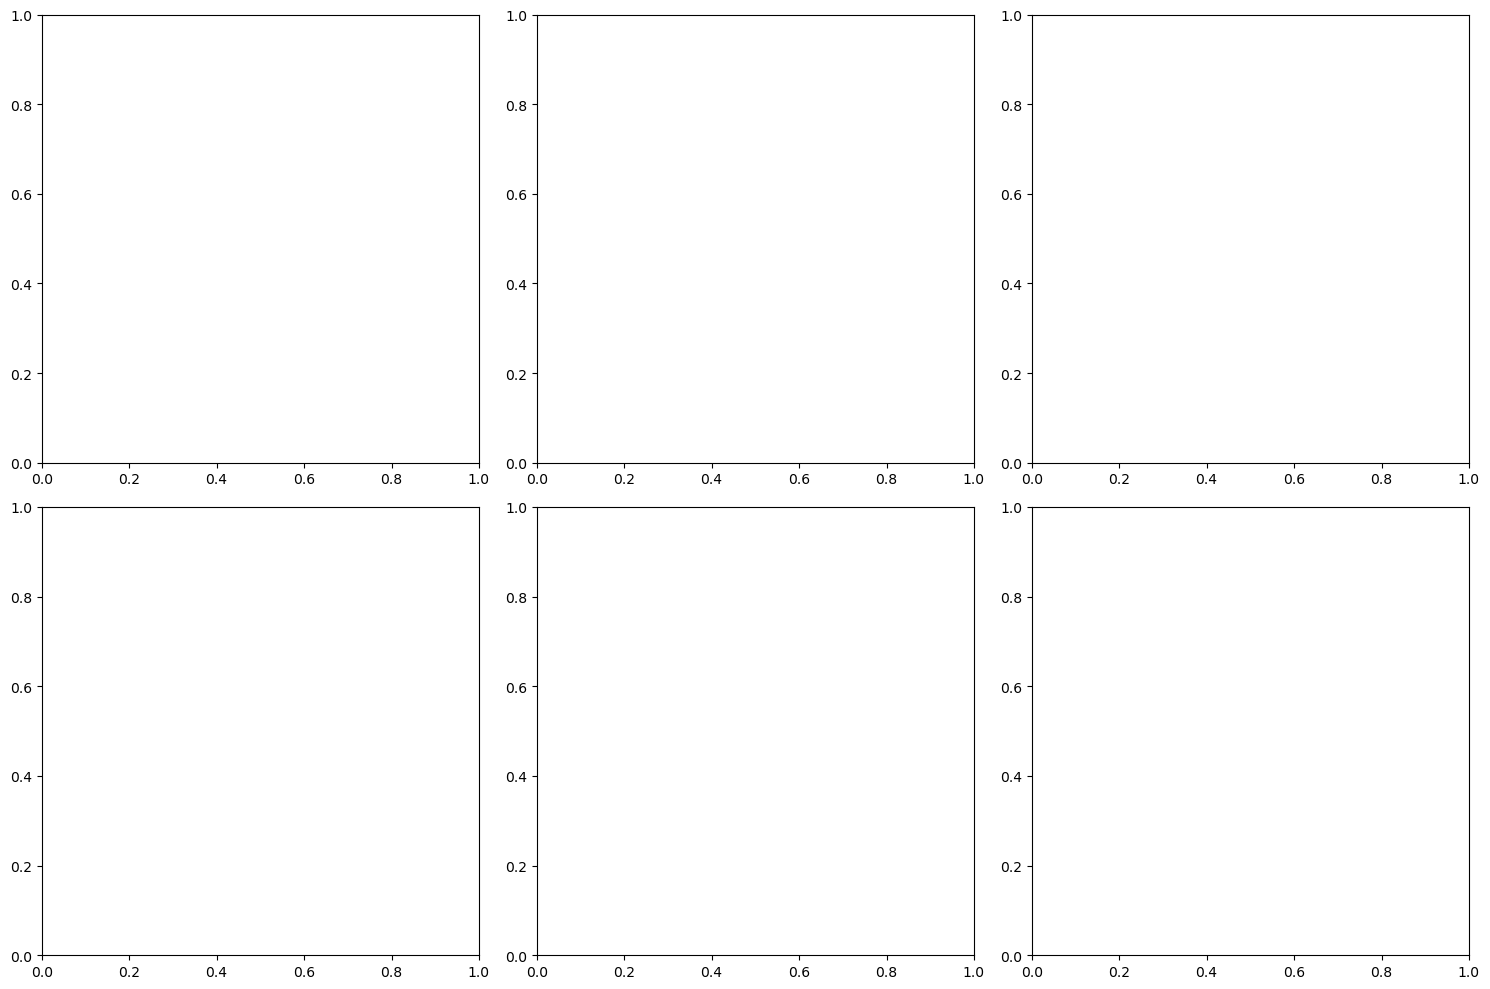

In [3]:
fig, axs = plt.subplots(ncols=3, nrows=1, squeeze=False, figsize=(15, 10), layout='tight')

current_t = run.neural_target.t.max()

plot_with_tail(axs[0,0], run.pro_latents, current_t, tail_length=2)
plot_with_tail(axs[0,1], run.jpca_latents, current_t, tail_length=2)
plot_with_tail(axs[0,2], run.ica_latents, current_t, tail_length=2)



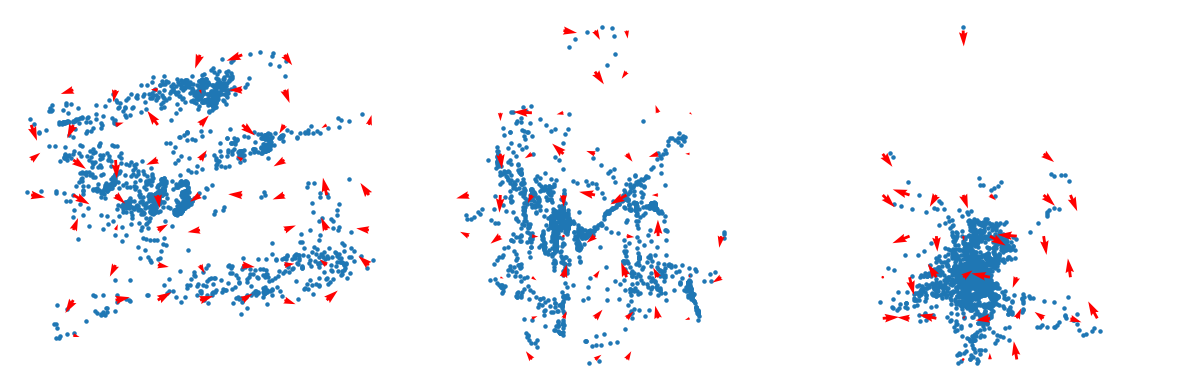

In [8]:
run.plot_flow_fields(grid_n=10)

## Stimulation figure

In [ ]:


latents = run.jpca_latents

desired_pattern = np.mean(latents[-101:-1], axis=0)
current_pattern = latents[-1]
desired_stim = desired_pattern - current_pattern

desired_pattern = (desired_stim @ run.pro.Q.T)[:run.d.neural_data.a.shape[-1]]

near_zero = np.abs(desired_stim) < 100
print(near_zero.sum())
desired_stim[near_zero] = np.nan


fig, ax = plt.subplots()
run.d.show_stim_pattern(ax, np.abs(desired_pattern))





In [ ]:
fig, ax = plt.subplots()
dim_1, dim_2 = 0,1
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)
ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')
ax.axis('equal');

